In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
youtube_data = pd.read_csv(r"C:\Users\idoka\Desktop\youtube_dataset.csv", index_col="video_id")

In [3]:
youtube_data.head()

,Unnamed: 0,published_at,title,channel_title,view_count,like_count,favorite_count,comment_count,duration,definition
video_id,,,,,,,,,,
uexN9gs5gvM,0,2023-05-04T19:01:39Z,Dei V x Myke Towers - Trending Remix (Official...,Dei V,14735004,117530.0,0,1076.0,00:04:33,hd
WXPfcRnz9Z8,1,2023-01-19T20:02:53Z,Trending - Dei V (Official Video),Dei V,6228419,62711.0,0,911.0,00:02:39,hd
K-mV_8aeQsk,2,2023-06-23T14:00:15Z,Most Unbelievable Moments Ever Caught On Camera !,Novella,7501791,38685.0,0,1138.0,00:11:04,hd
hplD4QyV4Q8,3,2019-02-24T03:00:05Z,Squash - Trending (Official Video),SquashVEVO,15445316,100024.0,0,2370.0,00:03:06,hd
XqHLbmM6Iew,4,2023-11-23T12:35:32Z,TRENDING રીધમ || ROHIT THAKOR || rohit thakor ...,SK OFFICIAL PUNAJ,1049158,14913.0,0,136.0,00:05:32,hd


### Step 1:
## Preprocessing

In [4]:
from datetime import timedelta

# Remove unnecessary columns
youtube_data.drop(['Unnamed: 0', 'favorite_count', 'definition', 'title', 'channel_title'], axis=1, inplace=True)

# Remove duplicates
youtube_data.drop_duplicates(inplace=True)

# Convert 'published_at' to datetime
youtube_data['published_at'] = pd.to_datetime(youtube_data['published_at'])

# Convert 'duration' to seconds
def duration_to_seconds(duration):
    try:
        time_parts = duration.split(':')
        return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + int(time_parts[2])
    except:
        return None

youtube_data['duration_seconds'] = youtube_data['duration'].apply(duration_to_seconds)

# Drop the original 'duration' column
youtube_data.drop('duration', axis=1, inplace=True)

# Check for missing values
youtube_data.isnull().sum()

published_at         0
view_count           0
like_count          47
comment_count       21
duration_seconds     0
dtype: int64

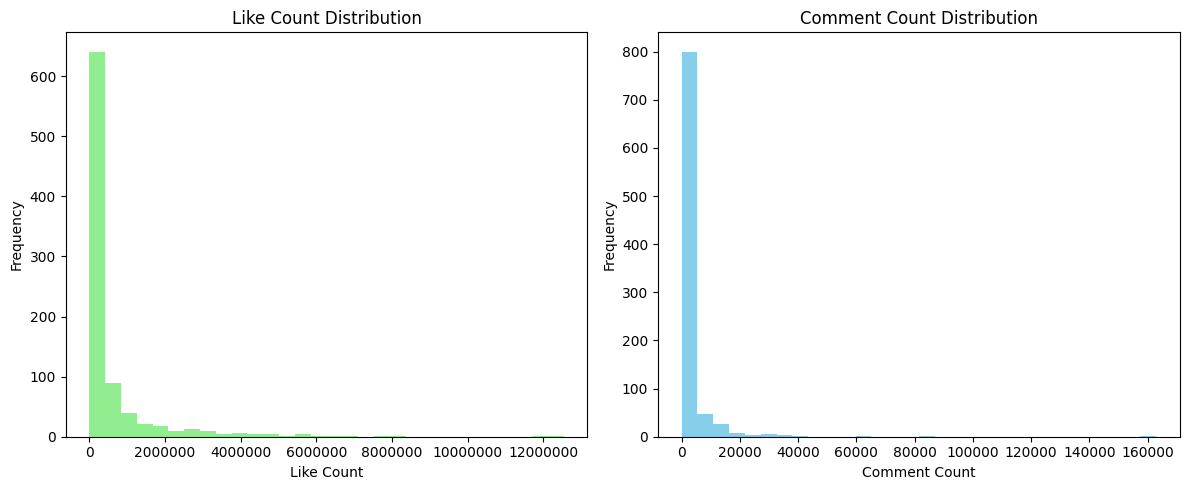

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for like_count
axs[0].hist(youtube_data['like_count'], bins=30, color='lightgreen')
axs[0].set_title('Like Count Distribution')
axs[0].set_xlabel('Like Count')
axs[0].set_ylabel('Frequency')
axs[0].ticklabel_format(style='plain', axis='x')
# axs[0].set_yscale('log')

# Histogram for comment_count
axs[1].hist(youtube_data['comment_count'], bins=30, color='skyblue')
axs[1].set_title('Comment Count Distribution')
axs[1].set_xlabel('Comment Count')
axs[1].set_ylabel('Frequency')
# axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

We can detect a few outliers in the data, with a high number of comments and likes.

With that kind of distributions, filling missing values with median will be better

In [6]:
youtube_data['like_count'] = youtube_data['like_count'].fillna(youtube_data['like_count'].median())
youtube_data['comment_count'] = youtube_data['comment_count'].fillna(youtube_data['comment_count'].median())

In [7]:
# Calculate the ratio of likes per view and comments per view
youtube_data['likes_per_view'] = youtube_data['like_count'] / youtube_data['view_count']
youtube_data['comments_per_view'] = youtube_data['comment_count'] / youtube_data['view_count']

youtube_data.head()

,published_at,view_count,like_count,comment_count,duration_seconds,likes_per_view,comments_per_view
video_id,,,,,,,
uexN9gs5gvM,2023-05-04 19:01:39+00:00,14735004,117530.0,1076.0,273,0.007976,0.000073
WXPfcRnz9Z8,2023-01-19 20:02:53+00:00,6228419,62711.0,911.0,159,0.010069,0.000146
K-mV_8aeQsk,2023-06-23 14:00:15+00:00,7501791,38685.0,1138.0,664,0.005157,0.000152
hplD4QyV4Q8,2019-02-24 03:00:05+00:00,15445316,100024.0,2370.0,186,0.006476,0.000153
XqHLbmM6Iew,2023-11-23 12:35:32+00:00,1049158,14913.0,136.0,332,0.014214,0.000130


### Step 2:
## Anomaly Detection

First we'll want to visualize the data.

Since our data have more then 3 dimetions, We'll use t-SNE algorithm for 2D visualization

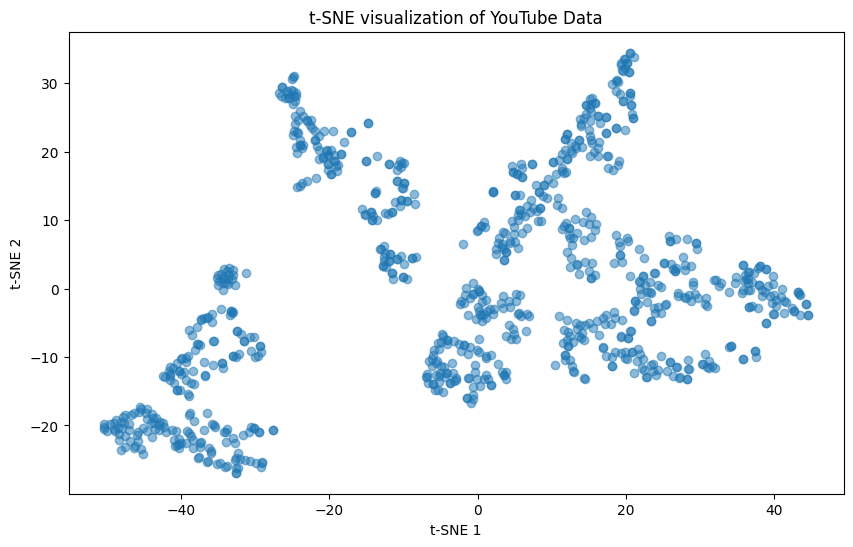

In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Calculate the number of days since the first video in the dataset was published
youtube_data['days_since_published'] = (youtube_data['published_at'] - youtube_data['published_at'].min()).dt.days

# Selecting a subset of relevant numerical features for t-SNE
features = ['view_count', 'like_count', 'comment_count', 'duration_seconds', 'days_since_published']
data_subset = youtube_data[features]

# Standardizing the data (necessary for t-SNE)
scalar = StandardScaler()
data_subset_scaled = scalar.fit_transform(data_subset)

# Applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(data_subset_scaled)

# Plotting the results of t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of YouTube Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

We can detect a cluster of samples in the left side of the plot, which is quiet different from the other samples

########################################

For Z-Score analysis, we need to assume a normal distribution for the data.

Let's perform a KS test to check whether the likes_per_view and comments_per_view follows a normal distribution 

In [9]:
from scipy.stats import kstest, norm

# Calculate mean and standard deviation for like_count and comment_count
mean_likes, std_likes = norm.fit(youtube_data['likes_per_view'])
mean_comments, std_comments = norm.fit(youtube_data['comments_per_view'])

# Perform KS Test for normality on likes_per_view and comments_per_view
ks_test_likes = kstest(youtube_data['likes_per_view'], 'norm', args=(mean_likes, std_likes))
ks_test_comments = kstest(youtube_data['comments_per_view'], 'norm', args=(mean_comments, std_comments))

# Results
ks_test_likes_result = ("KS Test for likes_per_view", ks_test_likes)
ks_test_comments_result = ("KS Test for comments_per_view", ks_test_comments)

ks_test_likes_result, ks_test_comments_result

(('KS Test for likes_per_view',
  KstestResult(statistic=0.15747102857693474, pvalue=1.952239237932027e-20, statistic_location=0.0006471658057265666, statistic_sign=-1)),
 ('KS Test for comments_per_view',
  KstestResult(statistic=0.34630303516147176, pvalue=2.767731535943496e-99, statistic_location=0.0, statistic_sign=-1)))

The very small p-values (close to zero) in both tests strongly reject the null hypothesis that the data comes from a normal distribution.

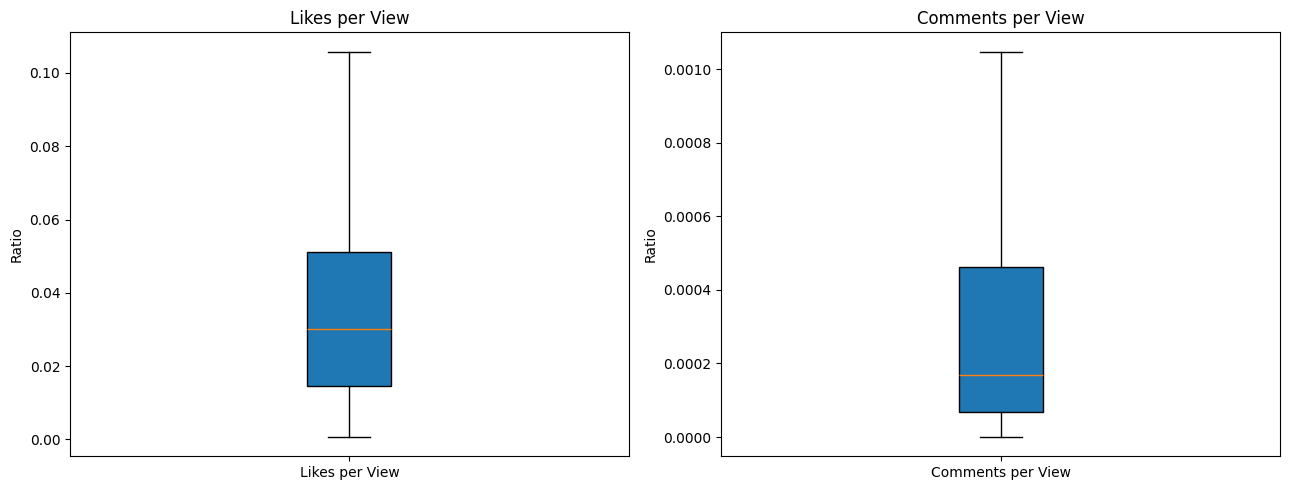

In [10]:
# Creating boxplots for likes_per_view and comments_per_view
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Boxplot for likes_per_view
axs[0].boxplot(youtube_data['likes_per_view'], vert=True, patch_artist=True, showfliers=False)
axs[0].set_title('Likes per View')
axs[0].set_ylabel('Ratio')
axs[0].set_xticklabels(['Likes per View'])

# Boxplot for comments_per_view
axs[1].boxplot(youtube_data['comments_per_view'], vert=True, patch_artist=True, showfliers=False)
axs[1].set_title('Comments per View')
axs[1].set_ylabel('Ratio')
axs[1].set_xticklabels(['Comments per View'])

plt.tight_layout()
plt.show()

From examine the two boxplots - Likes per View and Comments per View, seems like there's no outliers in the data...

Let's try the Modified Z-Score 

In [11]:
def modified_z_score(series):
    median_series = np.median(series)
    mad_series = np.median(np.abs(series - median_series))
    if mad_series == 0:
        return series * 0  # To handle constant columns, if any
    modified_z_scores = 0.6745 * (series - median_series) / mad_series
    return modified_z_scores

# Applying the modified Z-score calculation
youtube_data['mz_likes_per_view'] = modified_z_score(youtube_data['likes_per_view'])
youtube_data['mz_comments_per_view'] = modified_z_score(youtube_data['comments_per_view'])

# Filtering for outliers using a threshold of 3.5 for the Modified Z-Score
outliers_likes_mz = youtube_data[np.abs(youtube_data['mz_likes_per_view']) > 3.5]
outliers_comments_mz = youtube_data[np.abs(youtube_data['mz_comments_per_view']) > 3.5]

# Displaying the number of outliers detected
num_outliers_likes_mz = len(outliers_likes_mz)
num_outliers_comments_mz = len(outliers_comments_mz)

print(num_outliers_likes_mz, num_outliers_comments_mz)

27 142


We got 77 outliers, Lets examine some other techniques

In [12]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

models = {
    'LOF': LocalOutlierFactor(contamination=0.1),
    'Elliptic Envelope': EllipticEnvelope(contamination=0.1, support_fraction=1., random_state=42),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42),
    'One-Class SVM': OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
}

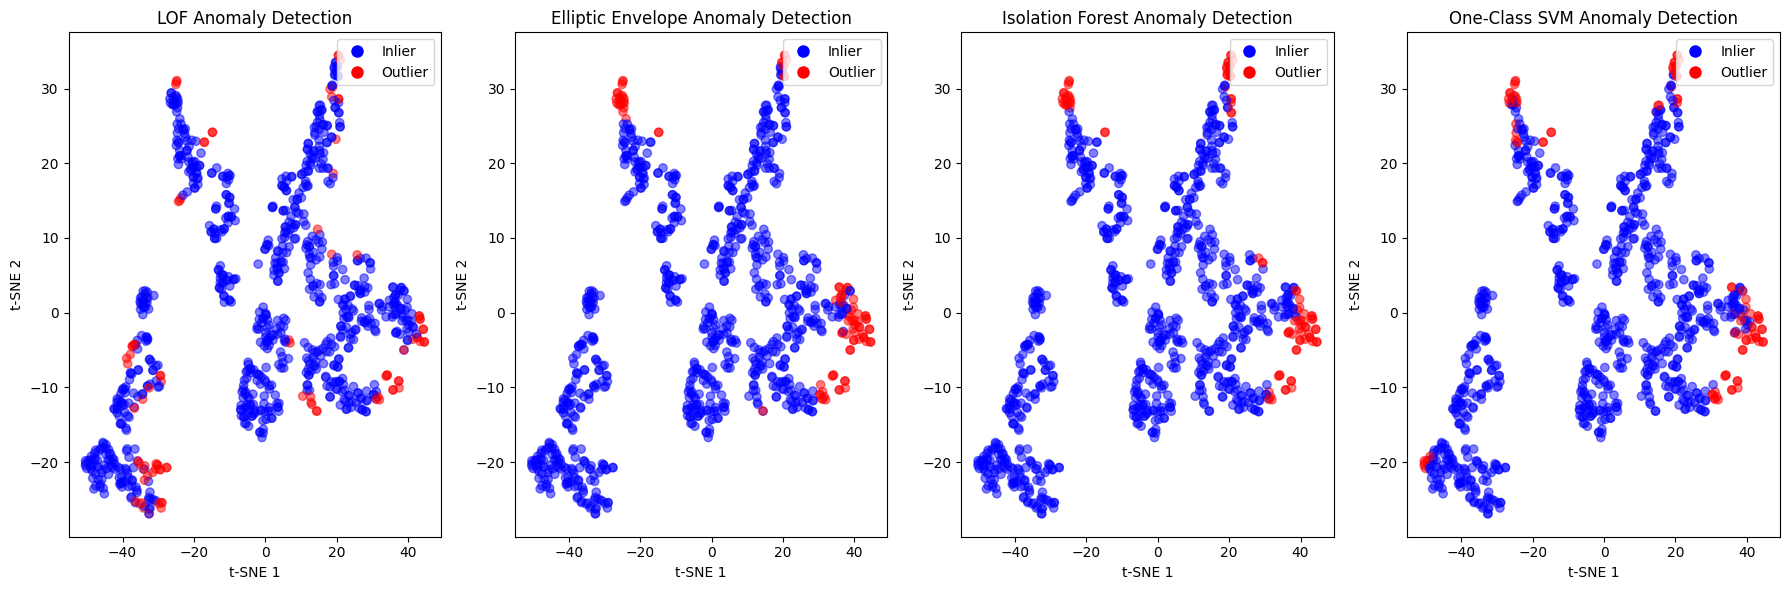

In [13]:
from matplotlib.lines import Line2D

# Setup for visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Define color map: -1 (outlier) -> red, 1 (inlier) -> blue
cmap = {1: 'blue', -1: 'red'}

predictions = []
for i, (name, model) in enumerate(models.items(), start=1):
    ax = axes[i-1]
    
    # For LOF and Elliptic Envelope, use fit_predict; for others, fit then predict
    if name in ['LOF', 'Elliptic Envelope']:
        preds = model.fit_predict(data_subset_scaled)
    else:
        model.fit(data_subset_scaled)
        preds = model.predict(data_subset_scaled)
    predictions.append(preds)
    
    # Map prediction to colors
    colors = [cmap[p] for p in preds]
    
    # Plotting
    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.5)
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inlier'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Outlier')]
    ax.legend(handles=legend_elements, loc='upper right')
    ax.set_title(f'{name} Anomaly Detection')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

Looks like all of the models detect outliers in the areas around (0, 20), (-20, 6), and (15, 6).

This consistency across different anomaly detection algorithms suggests a high confidence in these points being genuine outliers due to their distinct characteristics from the majority of the data.

In [14]:
# Convert list of predictions to a numpy array for easier analysis
predictions_array = np.array(predictions)

# Identify common outliers (-1 in all models)
common_outliers_mask = (predictions_array == -1).all(axis=0)

# Filter the scaled data for common outliers
common_outliers_scaled = data_subset_scaled[common_outliers_mask]

# Assuming data_subset is a DataFrame, to get the original data of common outliers:
common_outliers = data_subset.iloc[common_outliers_mask]

print(f"Number of common outliers detected by all models: {common_outliers_scaled.shape[0]}")
# Optionally, print indices or details of these common outliers
common_outliers

Number of common outliers detected by all models: 32


,view_count,like_count,comment_count,duration_seconds,days_since_published
video_id,,,,,
6bkHBVnID_M,55079412,3077246.0,30310.0,40,3198
nqzIQh2D_Es,333456133,1968340.0,65079.0,305,1061
aEkJWv8C4Z0,146072252,95088.0,82643.0,48,2972
ay99J4tUUu0,293435952,3441599.0,2618.0,16,2745
9tm_Xewwa84,118452593,7623404.0,6885.0,58,2470
i4nc8cY9Z6s,41456602,147450.0,6827.0,388,0
mRfVY9Wbnrs,15838301,640542.0,18748.0,2686,2235
LzZU2NItDVU,267183599,8243988.0,1980.0,32,2594
LzZU2NItDVU,267183599,8243989.0,1980.0,32,2594


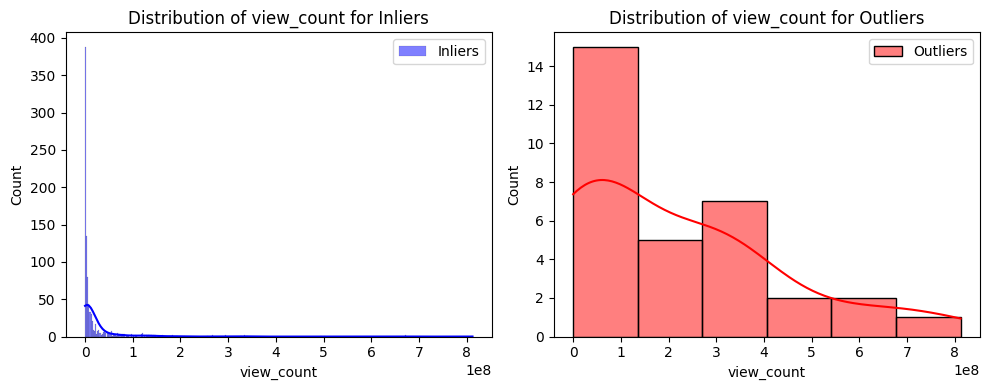

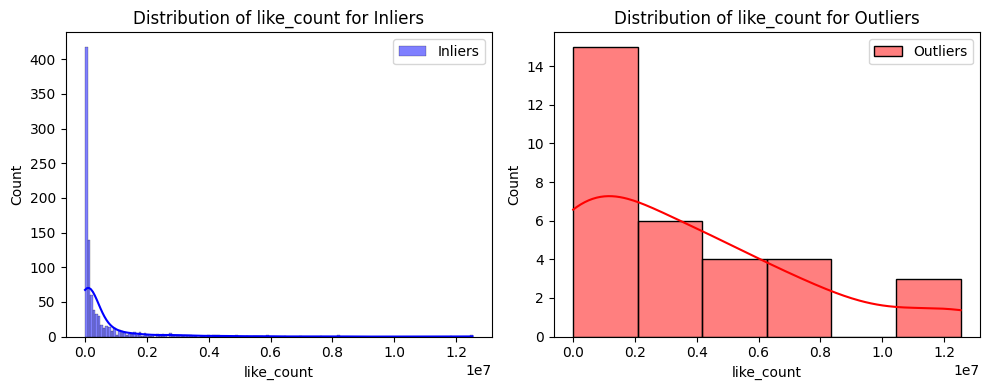

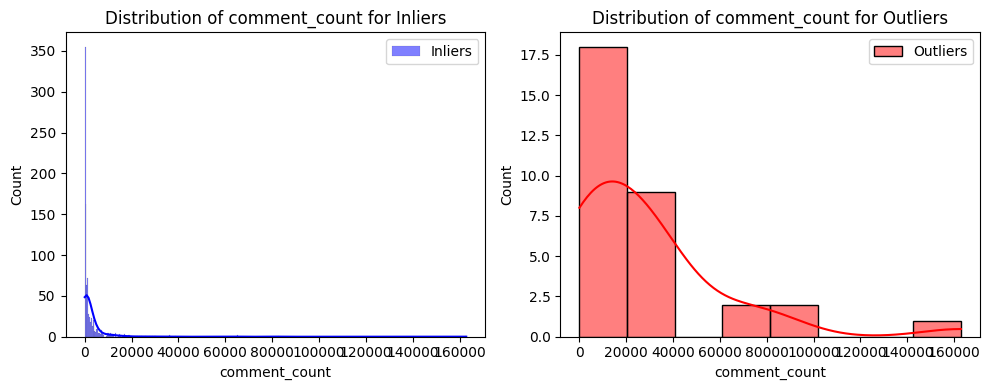

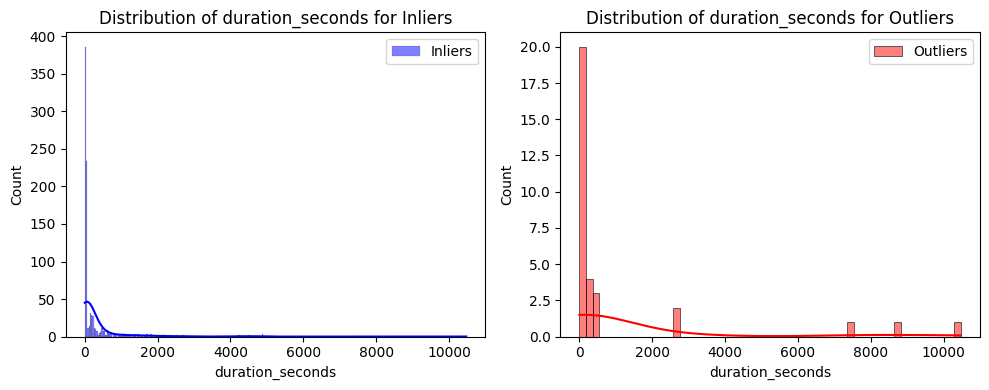

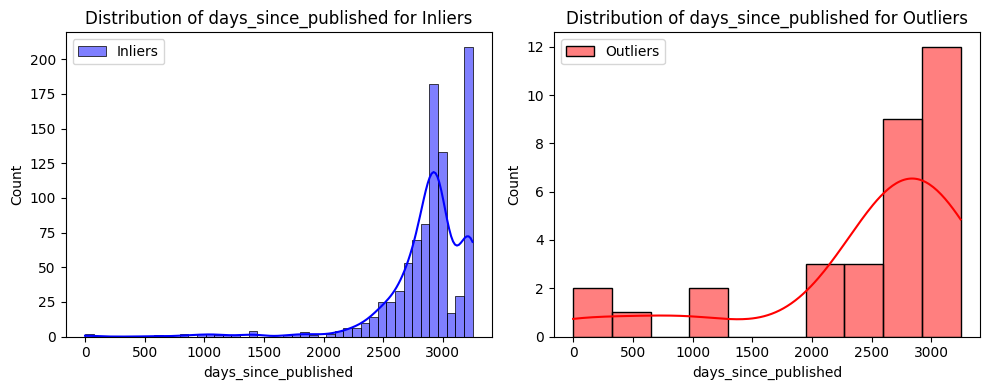

In [15]:
# Assuming `common_outliers` is a DataFrame of the common outliers
for column in common_outliers.columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data_subset[column], kde=True, color="blue", label="Inliers")
    plt.title(f'Distribution of {column} for Inliers')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.histplot(common_outliers[column], kde=True, color="red", label="Outliers")
    plt.title(f'Distribution of {column} for Outliers')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


#################################

### Step 3:
## Clustering

Text(0.5, 0.92, '3D PCA of the Dataset')

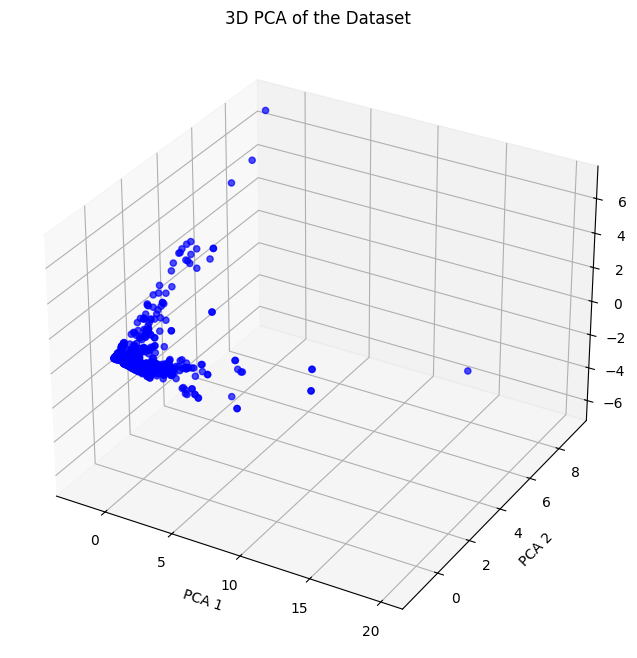

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_subset_scaled is your preprocessed dataset ready for PCA
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_subset_scaled)

# For 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the first three PCA components
ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], alpha=0.7, c='blue')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D PCA of the Dataset')


In [17]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.45830099 0.19980607 0.19202226]
0.8501293154168246


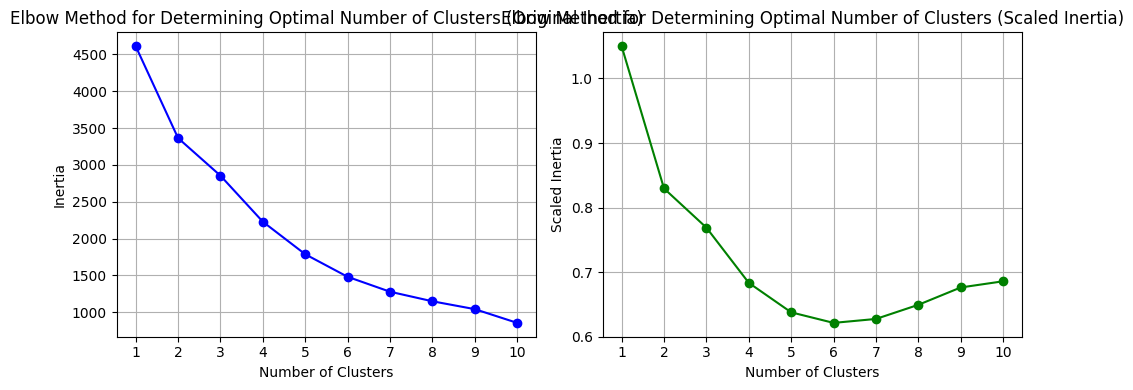

In [18]:
from sklearn.cluster import KMeans

alpha_k = 0.05  # Parameter for scaled inertia
inertia_values = []
scaled_inertia_values = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_subset_scaled)
    inertia_values.append(kmeans.inertia_)
    
    # Calculating scaled inertia
    inertia_o = np.square(data_subset_scaled - data_subset_scaled.mean(axis=0)).sum()
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    scaled_inertia_values.append(scaled_inertia)

# Plot the Elbow Curve for both original inertia and scaled inertia values side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for original inertia
axes[0].plot(range(1, 11), inertia_values, marker='o', color='blue')
axes[0].set_title('Elbow Method for Determining Optimal Number of Clusters (Original Inertia)')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(range(1, 11))
axes[0].grid(True)

# Plot for scaled inertia
axes[1].plot(range(1, 11), scaled_inertia_values, marker='o', color='green')
axes[1].set_title('Elbow Method for Determining Optimal Number of Clusters (Scaled Inertia)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Scaled Inertia')
axes[1].set_xticks(range(1, 11))
axes[1].grid(True)

plt.tight_layout()
plt.show()

By the "elbow" method, the right number of clusters is 5

For n_clusters = 2 The average silhouette_score is : 0.6011836010204639
For n_clusters = 3 The average silhouette_score is : 0.6435596647786642
For n_clusters = 4 The average silhouette_score is : 0.6292152499292545
For n_clusters = 5 The average silhouette_score is : 0.6367538343593807
For n_clusters = 6 The average silhouette_score is : 0.6048066253444603
For n_clusters = 7 The average silhouette_score is : 0.30730585753109785
For n_clusters = 8 The average silhouette_score is : 0.3228285703779781
For n_clusters = 9 The average silhouette_score is : 0.33016201862682537
For n_clusters = 10 The average silhouette_score is : 0.34557946217507574


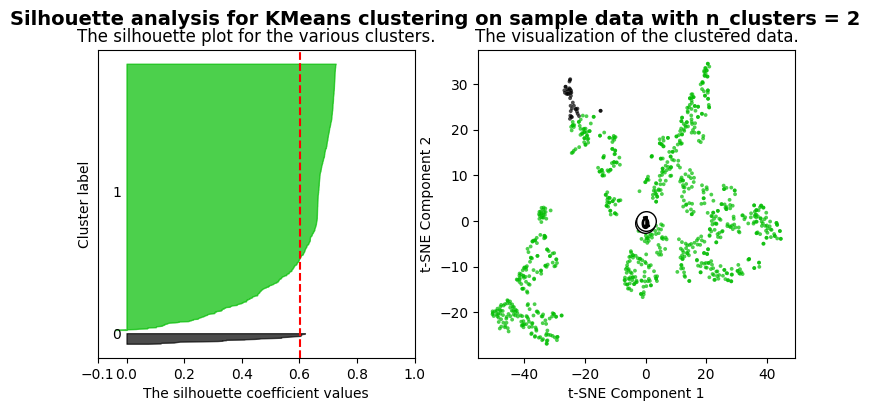

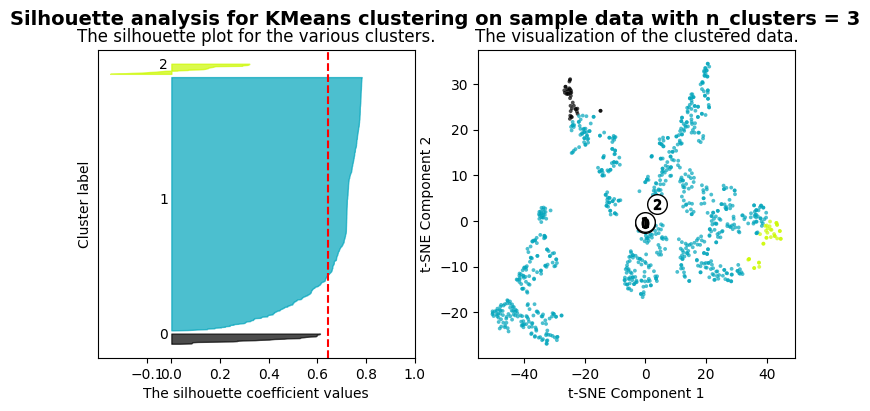

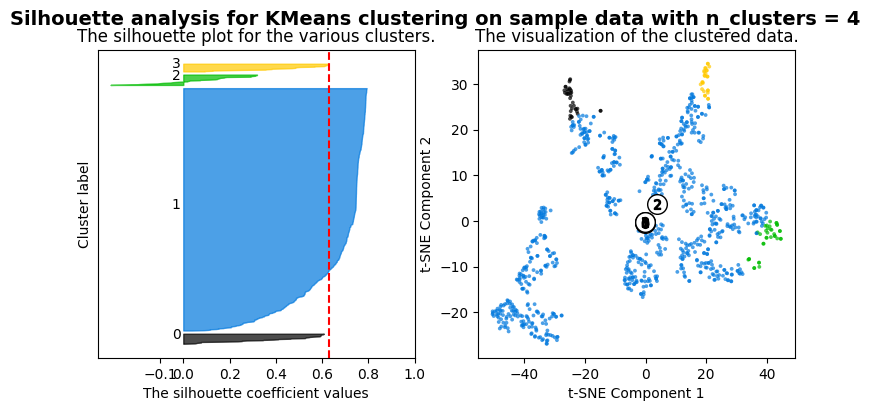

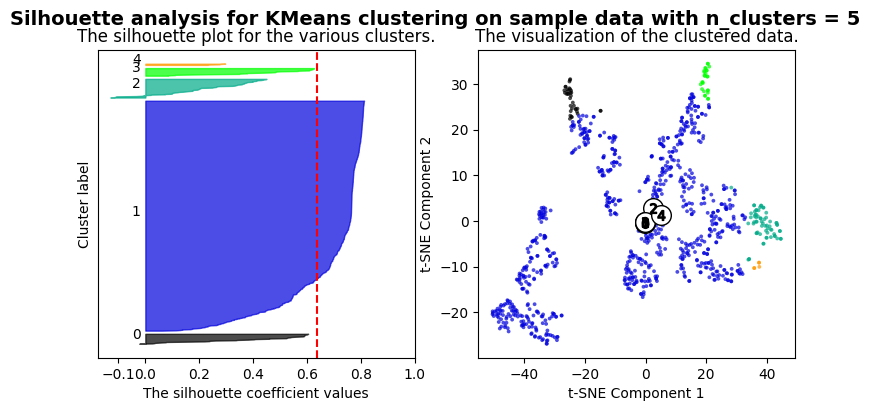

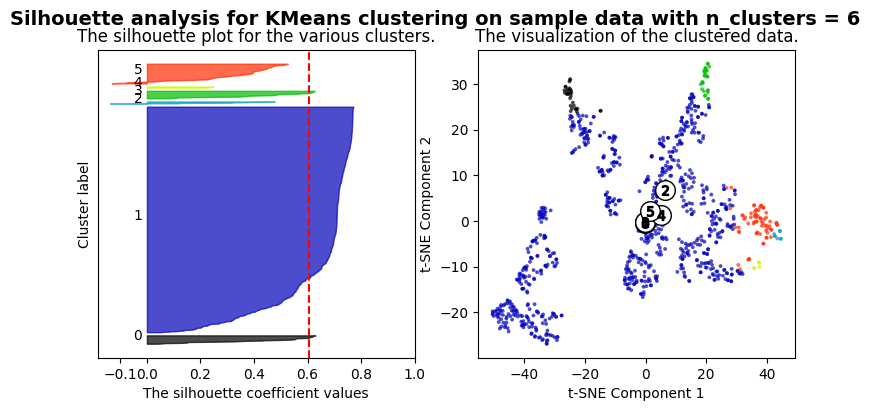

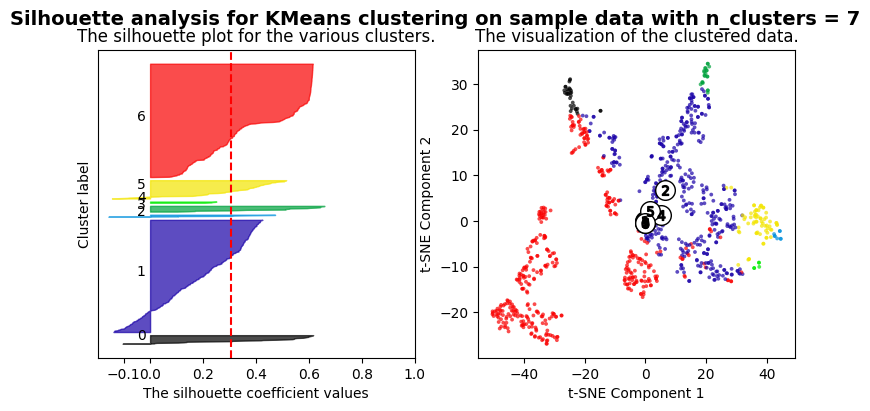

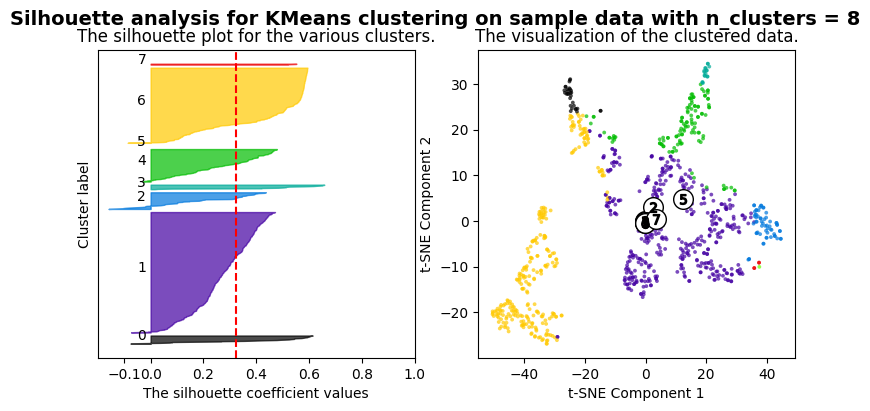

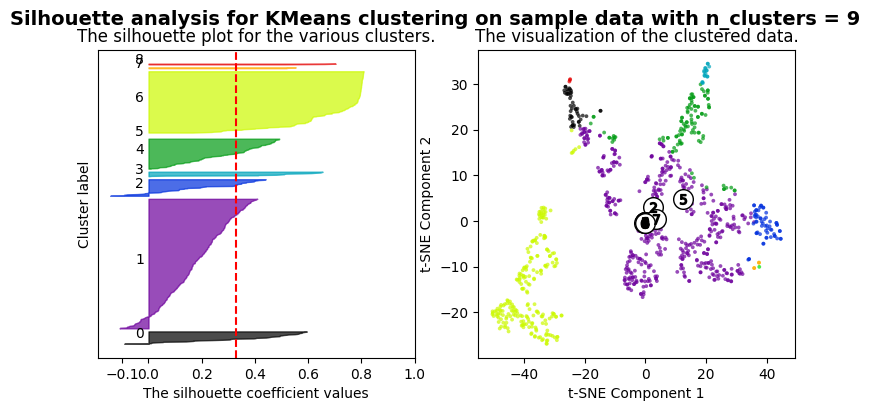

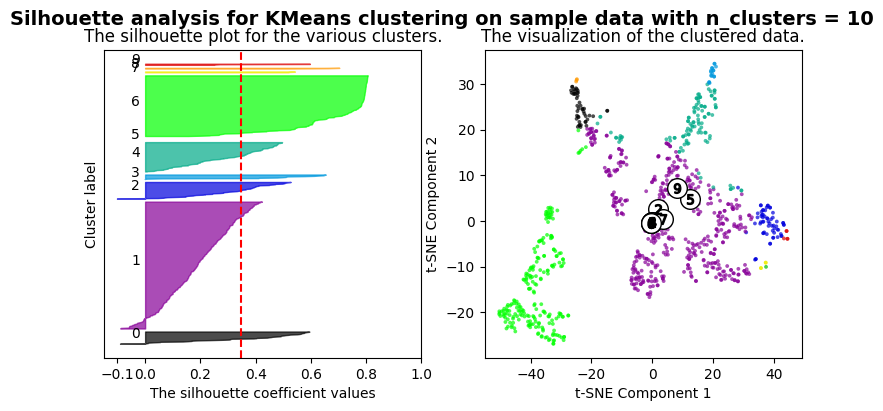

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Assuming 'data_subset_scaled' is the scaled dataset from your previous steps
range_n_clusters = list(range(2, 11))  # Adjust the range as needed

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 4)

    # Initialize the clusterer with n_clusters value and a random generator
    # seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_subset_scaled)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(data_subset_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_subset_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsne_results[:, 0], tsne_results[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("t-SNE Component 1")
    ax2.set_ylabel("t-SNE Component 2")

    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters, fontsize=14, fontweight='bold')
plt.show()


For n_clusters = 2, the average silhouette_score is: 0.6285111892745099
For n_clusters = 3, the average silhouette_score is: 0.6684800279676175
For n_clusters = 4, the average silhouette_score is: 0.5029549023693886
For n_clusters = 5, the average silhouette_score is: 0.601294914707396
For n_clusters = 6, the average silhouette_score is: 0.3388116934140207
For n_clusters = 7, the average silhouette_score is: 0.39400648450284803
For n_clusters = 8, the average silhouette_score is: 0.3790472789126321
For n_clusters = 9, the average silhouette_score is: 0.4207361770300156
For n_clusters = 10, the average silhouette_score is: 0.44927032554244045


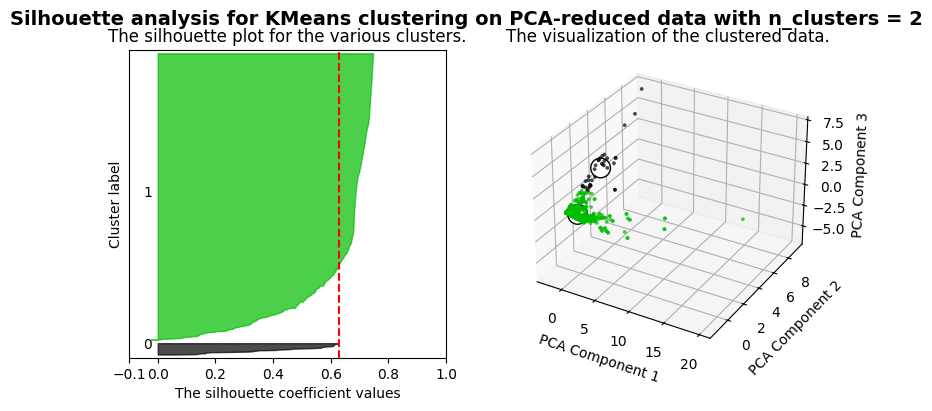

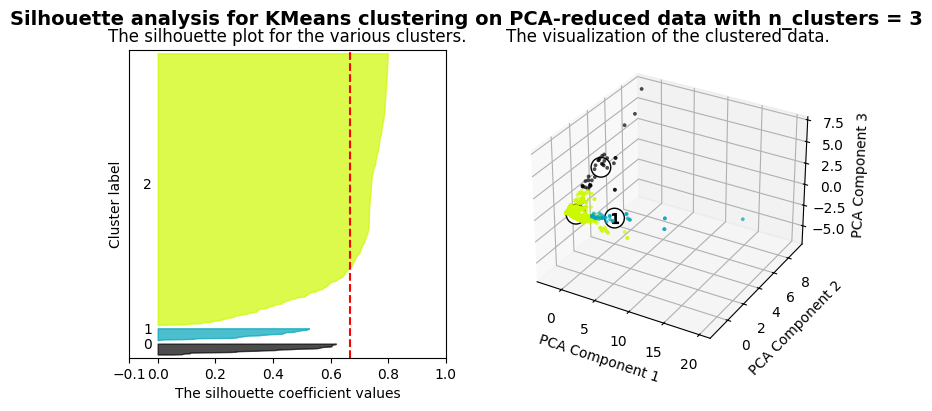

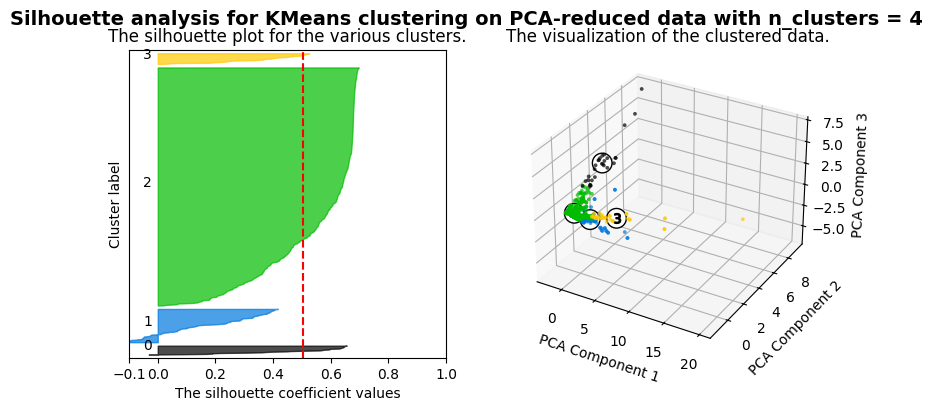

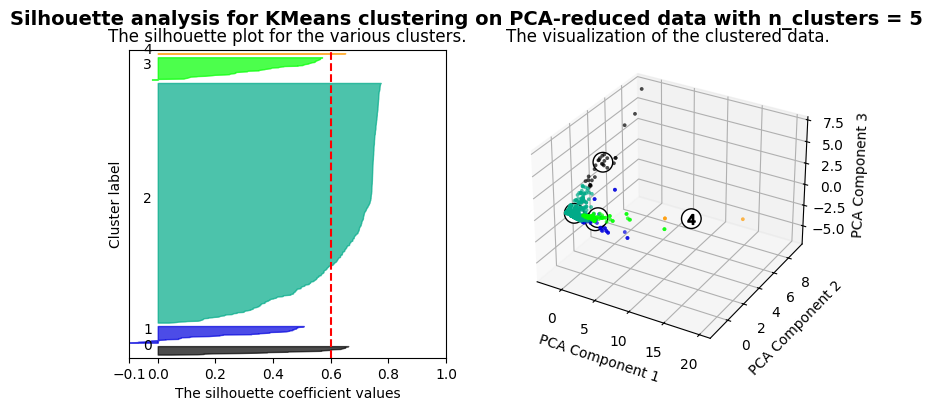

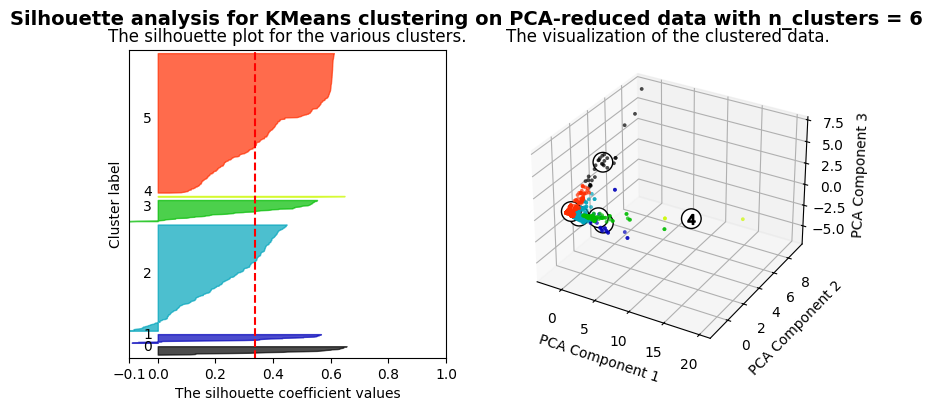

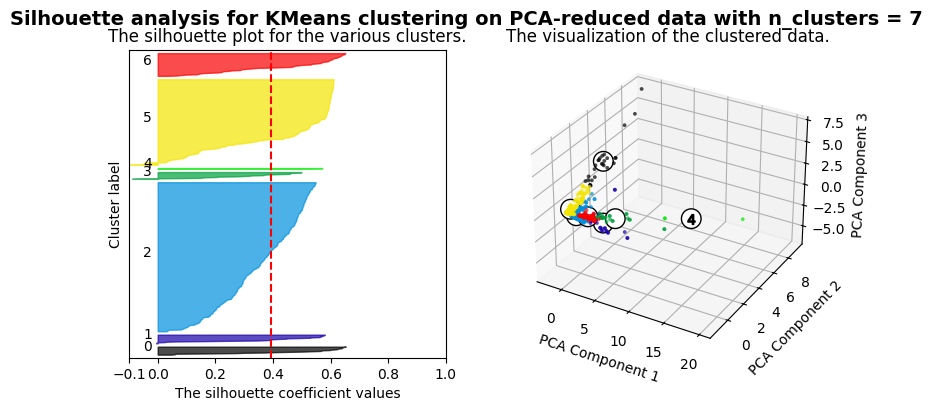

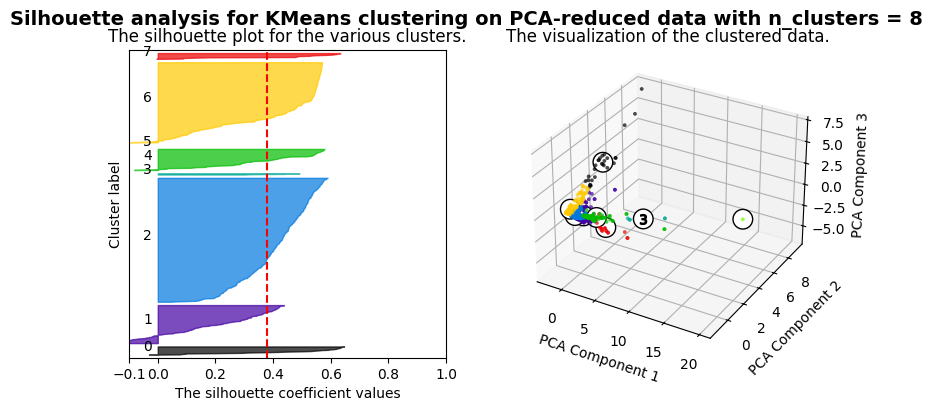

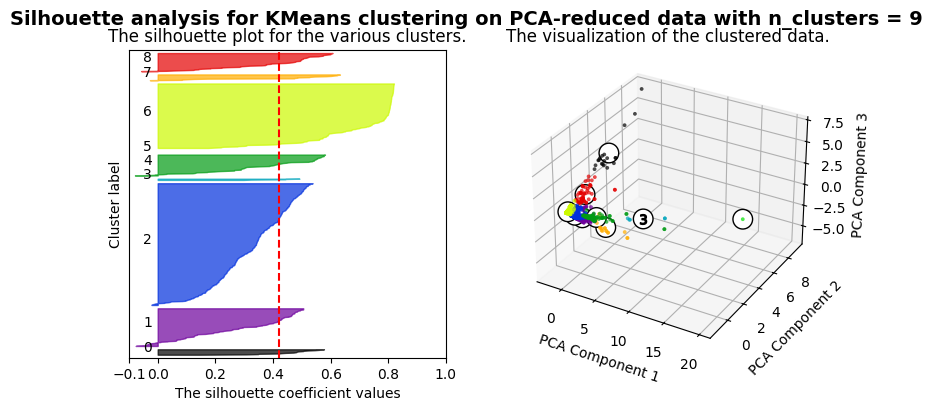

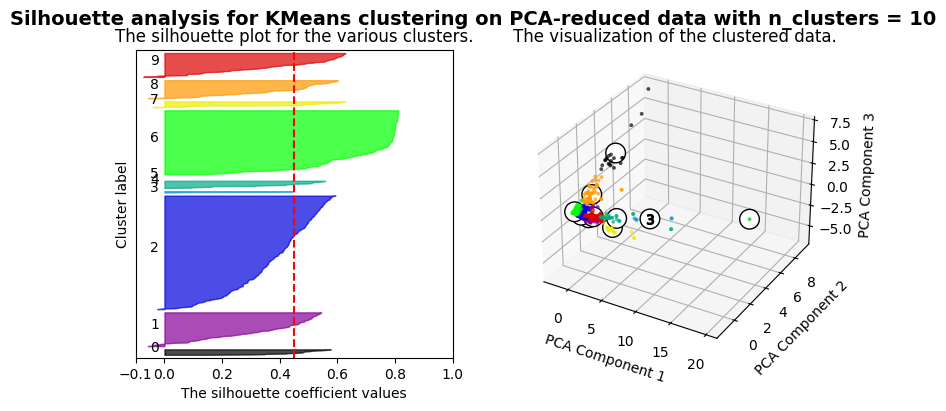

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'data_pca' is the PCA-reduced dataset ready for silhouette analysis
range_n_clusters = list(range(2, 11))  # Adjust the range as needed

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=(9, 4))

    # The 1st subplot is the silhouette plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_pca)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(data_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PCA Component 1")
    ax2.set_ylabel("PCA Component 2")
    ax2.set_zlabel("PCA Component 3")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on PCA-reduced data with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')

plt.show()


In [21]:
# optimal_k = 5  # Replace this with the optimal number of clusters you've determined
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# cluster_labels = kmeans.fit_predict(data_subset_scaled)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=cluster_labels, palette='viridis', s=50, alpha=0.6, edgecolor='k', legend='full')
# plt.title(f'Clusters Visualized on t-SNE Results with {optimal_k} Clusters')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(title='Cluster', loc='best')
# plt.grid(True)
# plt.show()

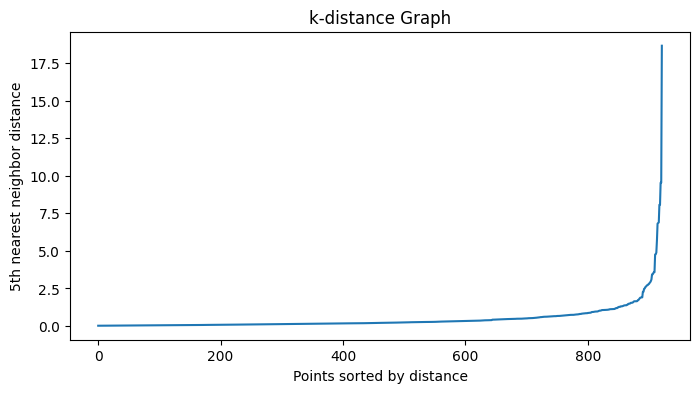

In [22]:
from sklearn.neighbors import NearestNeighbors

# Compute the k-distance graph
min_samples = 2 * len(data_subset.columns)  # A starting value for min_samples based on the number of features
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_subset_scaled)
distances, indices = neighbors_fit.kneighbors(data_subset_scaled)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:, min_samples-1]  # Use the distance to the 5th nearest neighbor

# Plot the k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.show()


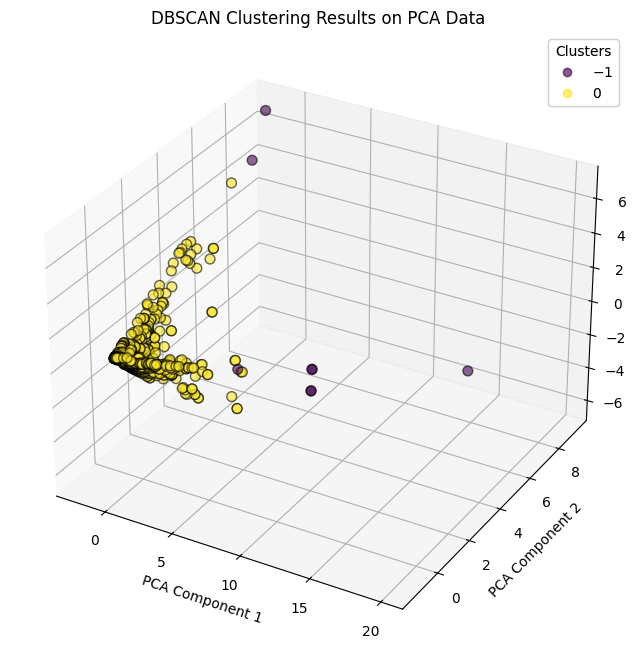

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# Applying DBSCAN to the PCA-reduced data
dbscan = DBSCAN(eps=3, min_samples=min_samples)  # You may need to adjust eps based on your dataset
dbscan_labels = dbscan.fit_predict(data_pca)

# Plot the DBSCAN clustering results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=dbscan_labels, cmap='viridis', s=50, alpha=0.6, edgecolor='k')

# Title and labels
ax.set_title('DBSCAN Clustering Results on PCA Data')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc='best')
ax.add_artist(legend1)

plt.show()



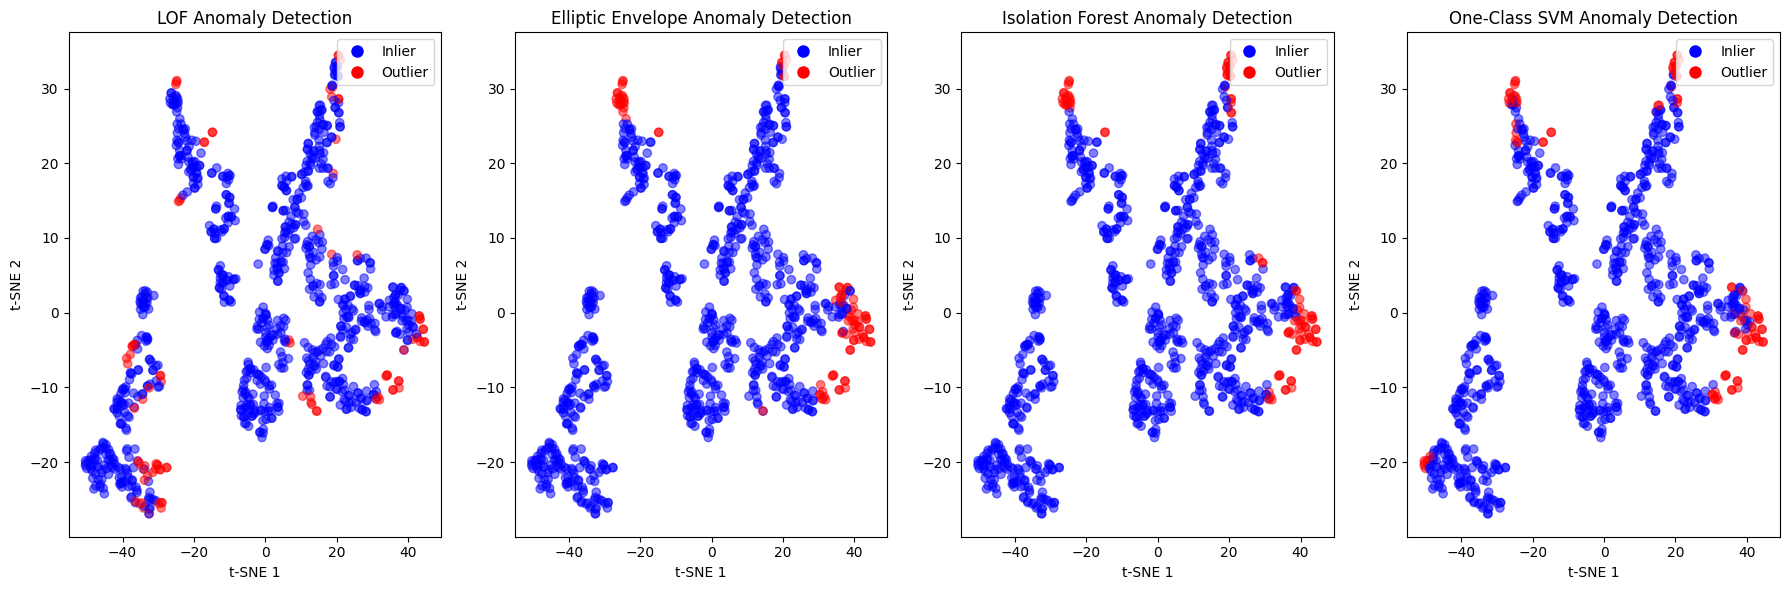

In [24]:
# test
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

models = {
    'LOF': LocalOutlierFactor(contamination=0.1),
    'Elliptic Envelope': EllipticEnvelope(contamination=0.1, support_fraction=1., random_state=42),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42),
    'One-Class SVM': OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
}
from matplotlib.lines import Line2D

# Setup for visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Define color map: -1 (outlier) -> red, 1 (inlier) -> blue
cmap = {1: 'blue', -1: 'red'}

predictions = []
for i, (name, model) in enumerate(models.items(), start=1):
    ax = axes[i-1]
    
    # For LOF and Elliptic Envelope, use fit_predict; for others, fit then predict
    if name in ['LOF', 'Elliptic Envelope']:
        preds = model.fit_predict(data_subset_scaled)
    else:
        model.fit(data_subset_scaled)
        preds = model.predict(data_subset_scaled)
    predictions.append(preds)
    
    # Map prediction to colors
    colors = [cmap[p] for p in preds]
    
    # Plotting
    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.5)
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inlier'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Outlier')]
    ax.legend(handles=legend_elements, loc='upper right')
    ax.set_title(f'{name} Anomaly Detection')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()